## Problem 6
Implement a multivariate normal simulation using the Cholesky root of a covariance matrix. Implement a multivariate normal simulation using PCA with percent explained as an input. Using the covariance matrix found in problem6.csv
- A. Simulate 10,000 draws using the Cholesky Root method.
- B. Simulate 10,000 draws using PCA with 75% variance
- C. Take the covariance of each simulation. Compare the Frobenius norm of these matrices
to the original covariance matrix. What do you notice?
- D. Compare the cumulative variance explained by each eigenvalue of the 2 simulated
covariance matrices along with the input matrix. What do you notice?
- E. Compare the time it took to run both simulations.
- F. Discuss the tradeoffs between the two methods.

In [8]:
import pandas as pd
import numpy as np
import time
from scipy.linalg import eigh, sqrtm
from numpy.linalg import norm

# Load the dataset and covariance matrix
data = pd.read_csv('problem6.csv')
cov_matrix = data
print(cov_matrix)

# Calculate the standard deviations
std_devs = np.sqrt(np.diag(cov_matrix))

# Create the initial correlation matrix
correlation_matrix = np.diag(1 / std_devs) @ cov_matrix @ np.diag(1 / std_devs)

# Function to modify the matrix by setting diagonal elements to 1
def set_diagonal_to_one(matrix):
    modified_matrix = matrix.copy()
    np.fill_diagonal(modified_matrix, 1)  # Set diagonal elements to 1
    return modified_matrix

# Function to adjust the matrix based on eigen decomposition
def adjust_matrix(matrix):
    eigenvalues, eigenvectors = eigh(matrix)  # Eigen decomposition
    eigenvalues[eigenvalues < 0] = 1e-8  # Avoid negative eigenvalues
    eigenvalues = np.diag(eigenvalues)  # Create diagonal matrix of eigenvalues
    return eigenvectors @ eigenvalues @ eigenvectors.T  # Reconstruct the matrix

# Convert the correlation matrix to a covariance matrix
def correlation_to_covariance(corr_matrix, std_devs):
    return np.diag(std_devs) @ corr_matrix @ np.diag(std_devs)

# Higham's algorithm to compute the nearest positive semidefinite matrix
tolerance = 1e-8
max_iterations = 1000
def higham_algorithm(matrix):
    Yk = matrix  # Initialize with the input matrix
    delta_Sk = np.zeros(matrix.shape)  # Initialize the delta matrix
    for iteration in range(max_iterations):
        Rk = Yk - delta_Sk
        Xk = adjust_matrix(Rk)
        delta_Sk = Xk - Rk
        if norm(Yk - set_diagonal_to_one(Xk), 'fro') < tolerance:  # Convergence check
            Yk = set_diagonal_to_one(Xk)
            print("Converged in iteration", iteration)  # Print iteration
            break
        Yk = set_diagonal_to_one(Xk)
    return Yk

# Apply Higham's algorithm to the correlation matrix and convert to covariance
higham_corr_matrix = higham_algorithm(correlation_matrix)
higham_cov_matrix = correlation_to_covariance(higham_corr_matrix, std_devs)

# Cholesky decomposition simulation for multivariate normal distribution
cholesky_decomp = np.linalg.cholesky(higham_cov_matrix)
num_samples = 10000  # Number of simulated samples
random_samples = np.random.randn(num_samples, cov_matrix.shape[0])  # Generate random samples
means = data.mean()  # Mean values from the data
generated_samples = []

# Measure execution time for Cholesky simulation
start_time_cholesky = time.time()
for sample in random_samples:
    generated_samples.append(cholesky_decomp @ sample + means)
end_time_cholesky = time.time()
execution_time_cholesky = end_time_cholesky - start_time_cholesky
print(f"Cholesky Simulation Execution Time: {execution_time_cholesky:.4f} seconds")

# Covariance of the generated samples from Cholesky simulation
simulated_cov_cholesky = pd.DataFrame(generated_samples).cov()

# PCA simulation with 75% variance explained
eigenvalues, eigenvectors = eigh(correlation_matrix)
samples_pca = []

# Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
reverse_indices = np.zeros_like(sorted_indices)
for idx, val in enumerate(sorted_indices):
    reverse_indices[val] = idx
reverse_indices = np.array(reverse_indices)

# Function for PCA transformation based on explained variance
def pca_transformation(variance_threshold):
    eigvals_sorted = eigenvalues[sorted_indices]  # Sorted eigenvalues
    eigvecs_sorted = eigenvectors[:, sorted_indices]  # Corresponding eigenvectors
    means_sorted = means[sorted_indices]  # Sorted means
    std_devs_sorted = std_devs[sorted_indices]  # Sorted std_devs
    
    # Calculate the cumulative variance
    positive_eigenvals = eigvals_sorted[eigvals_sorted > 0]
    cumulative_variance = np.cumsum(eigvals_sorted) / np.sum(positive_eigenvals)
    selected_components = (cumulative_variance <= variance_threshold) & (eigvals_sorted > 0)
    
    # Select the relevant eigenvectors and eigenvalues
    selected_eigenvalues = eigvals_sorted[selected_components]
    selected_eigenvectors = eigvecs_sorted[:, selected_components]
    
    # Create matrix B for PCA transformation
    B = selected_eigenvectors @ sqrtm(np.diag(selected_eigenvalues))
    cholesky_pca = np.diag(std_devs_sorted) @ B
    np.random.seed(1000)
    random_samples_pca = np.random.randn(num_samples, cholesky_pca.shape[1])  # Generate random samples
    for sample in random_samples_pca:
        samples_pca.append(cholesky_pca @ sample + means_sorted)

# Measure execution time for PCA simulation
start_time_pca = time.time()
pca_transformation(0.75)  # 75% variance explained
end_time_pca = time.time()
execution_time_pca = end_time_pca - start_time_pca
print(f"PCA Simulation Execution Time: {execution_time_pca:.4f} seconds")

# Reorder the PCA samples
samples_pca_df = pd.DataFrame(samples_pca)
samples_pca_df = samples_pca_df.iloc[:, reverse_indices]

# Covariance of the PCA simulated samples
simulated_cov_pca = samples_pca_df.cov()

# Frobenius norm calculations
frobenius_norm_cholesky = norm(cov_matrix.values - simulated_cov_cholesky.values, 'fro')
frobenius_norm_pca = norm(cov_matrix.values - simulated_cov_pca.values, 'fro')

print("Frobenius norm (Cholesky method):", frobenius_norm_cholesky)
print("Frobenius norm (PCA method):", frobenius_norm_pca)

           x1        x2        x3        x4        x5        x6        x7  \
0    0.005315  0.000215 -0.000777  0.000418 -0.000687  0.000166  0.000935   
1    0.000215  0.001781  0.000094 -0.000109 -0.000438  0.000523 -0.000803   
2   -0.000777  0.000094  0.004925  0.000320 -0.000592  0.000418 -0.000195   
3    0.000418 -0.000109  0.000320  0.002545 -0.000323 -0.000106  0.000165   
4   -0.000687 -0.000438 -0.000592 -0.000323  0.009133 -0.001379 -0.002163   
..        ...       ...       ...       ...       ...       ...       ...   
495 -0.000149 -0.000190 -0.000761  0.000310  0.001203 -0.000321 -0.000407   
496  0.000021  0.000009 -0.000269  0.000172  0.000028 -0.000077 -0.000186   
497  0.000237  0.000370 -0.000335  0.000148  0.000201 -0.000211  0.000027   
498  0.001169  0.000707  0.000360  0.000761 -0.001461 -0.000144 -0.000473   
499 -0.000095  0.000139 -0.000124  0.000240  0.000078 -0.000151 -0.000247   

           x8        x9       x10  ...      x491      x492      x493  \
0  

C:\Users\15322\AppData\Local\Temp\ipykernel_60064\2149193343.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means_sorted = means[sorted_indices]  # Sorted means


PCA Simulation Execution Time: 0.7967 seconds
Frobenius norm (Cholesky method): 0.020663517773627366
Frobenius norm (PCA method): 0.3267267428928945


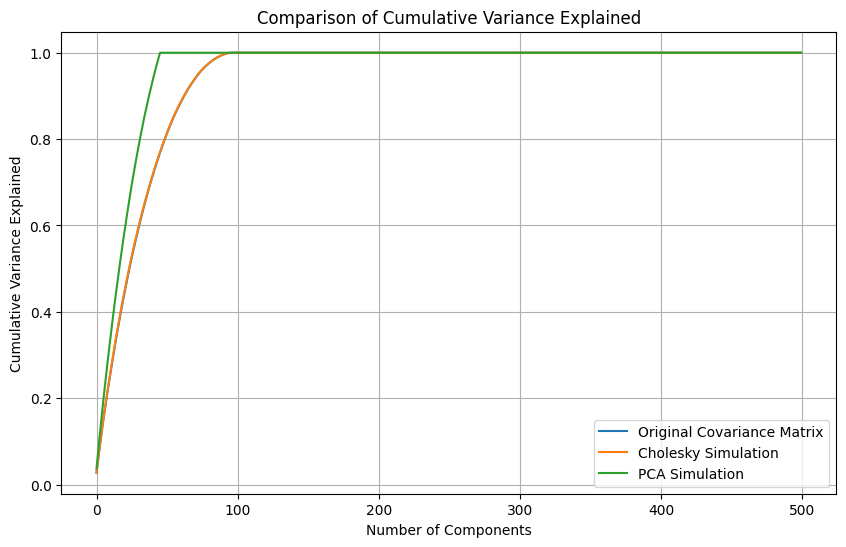

Cumulative variance for original covariance matrix:
[0.02761939 0.05418435 0.07962796 0.10481583 0.12919237 0.15320067
 0.17563346 0.19767436 0.21917739 0.24025578 0.26091835 0.28112831
 0.30123289 0.32109985 0.34021781 0.35891413 0.3771812  0.39525532
 0.41286727 0.43011022 0.44715547 0.4636013  0.47996073 0.49571076
 0.51142897 0.52652034 0.54106345 0.55554076 0.56978505 0.58370873
 0.59734631 0.61072527 0.62367645 0.63636435 0.648597   0.66077886
 0.67279265 0.68464285 0.69600906 0.70713825 0.71790311 0.72858805
 0.73884301 0.74903246 0.75901601 0.76889913 0.77836579 0.78742257
 0.79639387 0.80526487 0.813869   0.82233376 0.83046601 0.83850267
 0.84614709 0.85362782 0.86074911 0.86759656 0.87427735 0.88081977
 0.88713297 0.89334538 0.89950361 0.90534239 0.91096358 0.91654004
 0.9217448  0.92677263 0.93168606 0.93636474 0.94096476 0.94540556
 0.94973381 0.95379628 0.95769382 0.96134215 0.96465242 0.96784099
 0.97087969 0.97374815 0.97655565 0.97918366 0.98165612 0.98400844
 0.9862517

In [9]:
import matplotlib.pyplot as plt

# Eigenvalue decomposition for original covariance matrix
eigenvalues_original, _ = eigh(cov_matrix.values)
eigenvalues_original_sorted = np.sort(eigenvalues_original)[::-1]
cumulative_variance_original = np.cumsum(eigenvalues_original_sorted) / np.sum(eigenvalues_original_sorted)

# Eigenvalue decomposition for Cholesky simulated covariance matrix
eigenvalues_cholesky, _ = eigh(simulated_cov_cholesky.values)
eigenvalues_cholesky_sorted = np.sort(eigenvalues_cholesky)[::-1]
cumulative_variance_cholesky = np.cumsum(eigenvalues_cholesky_sorted) / np.sum(eigenvalues_cholesky_sorted)

# Eigenvalue decomposition for PCA simulated covariance matrix
eigenvalues_pca, _ = eigh(simulated_cov_pca.values)
eigenvalues_pca_sorted = np.sort(eigenvalues_pca)[::-1]
cumulative_variance_pca = np.cumsum(eigenvalues_pca_sorted) / np.sum(eigenvalues_pca_sorted)

# Plot cumulative variance for each covariance matrix
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_original, label='Original Covariance Matrix')
plt.plot(cumulative_variance_cholesky, label='Cholesky Simulation')
plt.plot(cumulative_variance_pca, label='PCA Simulation')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Comparison of Cumulative Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

# You can also print out the values for inspection
print("Cumulative variance for original covariance matrix:")
print(cumulative_variance_original)

print("Cumulative variance for Cholesky simulated covariance matrix:")
print(cumulative_variance_cholesky)

print("Cumulative variance for PCA simulated covariance matrix:")
print(cumulative_variance_pca)
